In [70]:
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from scipy import stats
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.cluster import AgglomerativeClustering

# Instructions
To run this notebook, you will need to download the Brainspan "Developmental Transcriptome Dataset", which can be found here: https://www.brainspan.org/static/download.html

Note where you save this data. May be simplest to put it in the ./data directory.



In [4]:
#this code will automatically pull the dataset for you and move it to the correct data/ folder
# os.system('wget https://www.brainspan.org/api/v2/well_known_file_download/267666525')
# os.system('mv genes_matrix_csv/** data/')

256

# Load brainspan data

I need to come back here and add the things I did to make these notebooks

In [5]:
ls /Users/jacobv/Science/Brainspan/

BrainSpan_data.tar.gz      genes_matrix_csv/
ForBslav/                  genes_matrix_csv.zip
gene_array_matrix_csv/     query.csv
gene_array_matrix_csv.zip


In [8]:
# Where to save figures
fig_dir = './figures/'
bspan_dir = './data/'

In [9]:
df = pandas.read_csv(os.path.join(bspan_dir,'expression_matrix.csv'),header=None) # expression data
rmd = pandas.read_csv(os.path.join(bspan_dir,'rows_metadata.csv')) # rows metadata
cmd = pandas.read_csv(os.path.join(bspan_dir,'columns_metadata.csv')) # columns metadata
print (len(rmd.gene_symbol.unique()))
print (df.shape,rmd.shape)

# address duplicates
rmd = rmd.drop_duplicates(subset=['gene_symbol'], keep='last')

labels = rmd.index.values
df = df.loc[df.index.intersection(labels)]
print (df.shape,rmd.shape)


47808
(52376, 525) (52376, 5)
(47808, 525) (47808, 5)


#### Prepare phenotypic information for analysis

In [24]:
gdf = pandas.DataFrame(cmd,copy=True)

In [25]:
order = ['8 pcw', '9 pcw', '12 pcw', '13 pcw', '16 pcw', 
         '17 pcw', '19 pcw', '21 pcw','24 pcw', '25 pcw', 
         '26 pcw', '35 pcw', '37 pcw','4 mos','10 mos',
         '1 yrs', '2 yrs', '3 yrs','4 yrs','8 yrs',
        '11 yrs', '13 yrs', '15 yrs', '18 yrs', '19 yrs',
        '21 yrs', '23 yrs','30 yrs', '36 yrs', '37 yrs',
        '40 yrs']

# stage
fetal = ['8 pcw', '9 pcw', '12 pcw', '13 pcw', '16 pcw', 
         '17 pcw', '19 pcw', '21 pcw','24 pcw', '25 pcw', 
         '26 pcw', '35 pcw', '37 pcw',]
infant = ['4 mos','10 mos','1 yrs',]
child = ['2 yrs', '3 yrs','4 yrs','8 yrs',]
adolescent = ['11 yrs', '13 yrs', '15 yrs', '18 yrs', '19 yrs',]
adult = ['21 yrs', '23 yrs','30 yrs', '36 yrs', '37 yrs',
        '40 yrs']
divs = [fetal,infant,child,adolescent,adult]
names = ['fetal','infant','child','adolescent','adult']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.age.isin(div)].index,'Age_Stage'] = name

#epoch
e0 = ['8 pcw', '9 pcw']
e1 = ['12 pcw', '13 pcw', '16 pcw', '17 pcw', '19 pcw']
e2 = ['21 pcw','24 pcw', '25 pcw', '26 pcw', '35 pcw', 
      '37 pcw','4 mos']
e3 = ['10 mos','1 yrs','2 yrs', '3 yrs','4 yrs','8 yrs',
        '11 yrs', '13 yrs', '15 yrs', '18 yrs', '19 yrs',
        '21 yrs', '23 yrs','30 yrs', '36 yrs', '37 yrs',
        '40 yrs']
divs = [e0,e1,e2,e3]
names = ['e0','e1','e2','e3']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.age.isin(div)].index,'Age_Epoch'] = name

#period
p2 = ['8 pcw', '9 pcw']
p3 = ['12 pcw', '13 pcw',]
p4 = ['16 pcw']
p5 = ['17 pcw', '19 pcw']
p6 = ['21 pcw','24 pcw']
p7 = ['25 pcw', '26 pcw', '35 pcw','37 pcw']
p8 = ['4 mos']
p9 = ['10 mos','1 yrs']
p10 = ['2 yrs', '3 yrs','4 yrs',]
p11 = ['8 yrs','11 yrs',]
p12 = ['13 yrs', '15 yrs', '18 yrs', '19 yrs','21 yrs',
       '23 yrs','30 yrs', '36 yrs', '37 yrs','40 yrs']
divs = [p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12]
names = ['p2','p3','p4','p5','p6','p7','p8','p9',
         'p10','p11','p12']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.age.isin(div)].index,'Age_Period'] = name


In [26]:
# brain divisions

Occipital =  ['Ocx','V1C']
Somatomotor=['M1C-S1C','M1C','S1C']
Limbic=['AMY','HIP']
GangEm= ['MGE','CGE','LGE']
Temporal=['STC','ITC','TCx','A1C']
Cerebellum=['URL','CB','CBC']
Subcortex=['DTH','STR','MD']
Frontal=['MFC','DFC','OFC','VFC']
Parietal=['PCx','IPC']

Striatum = ['STR']
Thalamus = ['MD','DTH']
             
divs = [Occipital,Somatomotor,Limbic,GangEm,Temporal,Cerebellum,Subcortex,Frontal,Parietal]
names = ['Occipital','Somatomotor','Limbic','GangEm','Temporal','Cerebellum','Subcortex','Frontal','Parietal']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.structure_acronym.isin(div)].index,'MacroStructure'] = name

divs = [Occipital,Somatomotor,Limbic,GangEm,Temporal,Cerebellum,Frontal,Parietal,Striatum,Thalamus]
names = ['Occipital','Sensorimotor','Limbic','GangEm','Temporal','Cerebellum','Frontal','Parietal','Striatum','Thalamus']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.structure_acronym.isin(div)].index,'MacroStructure2'] = name
    
Tele = ['Ocx','AMY','M1C-S1C','MGE','STC',
                  'CGE','DTH','MFC','DFC','OFC','LGE',
                  'ITC','HIP','VFC','PCx','TCx','IPC',
                  'A1C','V1C','STR','M1C','S1C','MD']
Met = ['URL','CB','CBC']
divs = [Tele,Met]
names = ['Tele','Met']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.structure_acronym.isin(div)].index,'NT_Segment'] = name

Sensory = ['M1C-S1C','A1C','V1C','M1C','S1C']
Association = ['Ocx','AMY','STC','MFC',
            'DFC','OFC','ITC','HIP',
            'VFC','PCx','TCx','IPC']
Not_Cortex = ['MGE','URL','CGE','DTH',
          'LGE','STR','CB','CBC','MD']
divs = [Sensory,Association,Not_Cortex]
names = ['Sensory','Association','Not_Cortex']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.structure_acronym.isin(div)].index,'Sensorifugal'] = name


In [27]:
# get log age
# deal with the nine months before birth before logging...
for i,row in gdf.iterrows():
    age = row['age']
    num,measure = age.split(' ')
    if measure == 'pcw':
        fage = int(num) / 4.35
    elif measure == 'yrs':
        fage = int(num) * 12
    else:
        fage = int(num)
    gdf.loc[i,'age_in_months'] = fage

In [28]:
# same thing for weeks
for i,row in gdf.iterrows():
    age = row['age']
    num,measure = age.split(' ')
    if measure == 'pcw':
        fage = int(num)
    elif measure == 'yrs':
        fage = (int(num) * 52) + 39.105
    else:
        fage = (int(num) * 4.345) + 39.105
    gdf.loc[i,'age_in_weeks'] = fage

In [29]:
gdf.loc[:,'log_age_months'] = np.log(gdf['age_in_months']).values
gdf.loc[:,'log_age_weeks'] = np.log(gdf['age_in_weeks']).values


In [30]:
code = dict(zip(gdf.age.unique(),range(len(gdf.age.unique()))))
gdf.loc[:,'age_level'] = [code[x] for x in gdf.age.values]

# Harmonize datasets

#### Load component data

In [10]:
# We created this notebook in NB3_PLS_ModelExploration
all_comps = pandas.read_csv('./tables/all_comps.csv',index_col=0)

#### harmonize genes

In [11]:
shared = list(set(rmd.gene_symbol.values) & set(all_comps.gene_symbol))
len(shared)

13786

In [12]:
good_ids = rmd[rmd.gene_symbol.isin(shared)].index
gxp = df.loc[good_ids]
gxp.shape

(13786, 525)

In [13]:
gxp.index = rmd[rmd.gene_symbol.isin(shared)].gene_symbol.values
gxp.drop(gxp.columns[0],axis=1,inplace=True) # get rid of index column
gxp.head()

,1,2,3,4,5,6,7,8,9,10,...,515,516,517,518,519,520,521,522,523,524
TSPAN6,36.447128,24.251253,19.330479,27.668607,19.998231,14.680673,27.548101,16.580183,44.587799,44.943915,...,2.320932,1.781548,2.277359,1.832737,1.555696,2.081944,3.484685,4.816781,3.034464,3.082820
DPM1,34.373239,20.765661,18.734947,22.366394,19.228431,11.020365,25.394607,17.671327,32.903100,38.157569,...,23.769167,20.142132,20.063257,16.575379,18.783516,21.631293,28.006120,28.731717,16.679597,28.866042
SCYL3,4.379337,4.227521,2.551825,3.603764,2.948976,2.405183,3.613642,2.573935,3.483817,3.609830,...,1.593009,1.563377,1.648571,2.231466,2.040326,2.161741,1.275352,1.184766,1.735579,1.500363
C1orf112,3.957119,3.520794,2.037805,3.487035,2.177235,0.999693,3.481555,1.747568,3.741580,3.560650,...,0.583488,0.797376,0.607141,0.575555,0.606445,0.683625,0.495084,0.761265,0.766482,0.468859
FGR,0.244174,0.266976,0.248188,0.141398,0.467688,0.296493,0.079941,0.149822,0.204210,0.260205,...,1.319251,2.062175,1.168233,0.681609,0.490367,0.407953,1.568014,1.260039,1.736395,1.632879


#### Get gene expression for each component and each columns
As with NB05, we will do a careful approach that allows us to generalize the AHBA PLS model to the BrainSpan dataset. This will once again involve normalizing the brainspan data (using adult data!), refitting the PCA and PLS models in the Allen data based on the shared gene set, and applying those models directly to the Brainspan data

In [14]:
# Generated in NB1
hbigdf = pandas.read_csv('data/expression.csv') 
allendir = '/Users/jacobv/abagen-data/microarray/'
probes = pandas.read_csv(os.path.join(allendir,'normalized_microarray_donor10021/Probes.csv'))
# Generated in NB2
hgdf = pandas.read_csv('data/PLS_GXp_gdf.csv',index_col=0) # Generated in NB2
hbigdf.index = hgdf.index
hbigdf.drop('well_id',axis=1,inplace=True)

In [15]:
# reduced to only shared genes
hbigdf = hbigdf[gxp.index]

In [33]:
# fit PCA and PLS model on the AHBA (shared) gene set

n_comps=3
pcamod = PCA(n_components=100, random_state=123).fit(hbigdf)
pca_tfm = pandas.DataFrame(pcamod.transform(hbigdf),index = hgdf.index)
full_y = hgdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
pls_mod = PLSRegression(n_components=n_comps)
pls_mod.fit(pca_tfm, full_y)

PLSRegression(n_components=3)

In [34]:
# apply to Brainspan

# 0-1 normalization of Brainspan data using adult data (to match AHBA data distribution)
mmmod = MinMaxScaler().fit(gxp.T.loc[gdf[gdf.Age_Stage=='adult'].index])

# fit AHBA PCA then PLS model to brainspan data
hb_pcatfm = pcamod.transform(mmmod.transform(gxp.T))
xtfm = pls_mod.transform(hb_pcatfm)
for c in range(n_comps):
    gdf.loc[:,'C%s_exp'%(c+1)] = xtfm[:,c]

In [66]:
## if you want to save the harmonized dataset, uncomment below
# gdf.to_csv('data/GCorr_Brainspan.csv')

In [67]:
## if you want to load your saved harmonized dataset, uncomment below
#gdf = pandas.read_csv('data/GCorr_Brainspan.csv',index_col=0)

# Plot component dispersion across brainspan

First we'll just look at regions at one side or the other of each gradient, to see how expression of the component in these regions changes over the lifespan. This is not super informative because we are not accounting for the random effect of donor, but it should still gives us a general sense of what's going on

Text(0.5, 15.439999999999998, 'log age (weeks)')

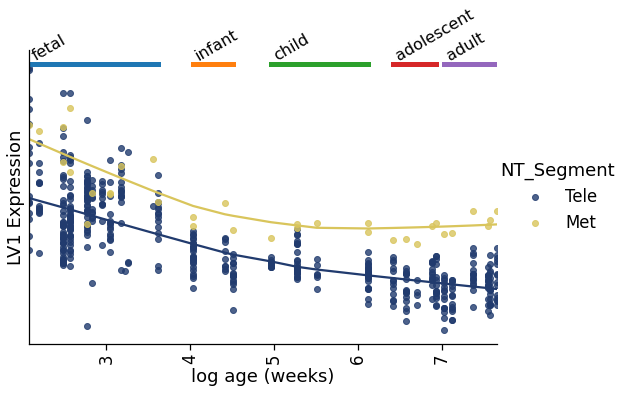

In [38]:
# C1

# plot
rbpal = [sns.color_palette('cividis')[-1],
                      sns.color_palette('cividis')[0]]
g = sns.lmplot(x='log_age_weeks',y='C1_exp',aspect=1.5,
               data=gdf,
               #[gdf['C1_exp']<1000],
           hue='NT_Segment',lowess=True,
              palette=rbpal[::-1])
g.set_xticklabels(rotation=90)

# decorate to show age stage in dataset 
for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[5,5],lw=5)
    #loc = xmin + (xmax-xmin)*.5
    plt.text(xmin,5,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.ylabel('LV1 Expression')
plt.yticks([])
plt.xlabel('log age (weeks)')
#plt.savefig(os.path.join(fig_dir,'BS_Devel_C1.pdf'),bbox_inches='tight')

Text(0.5, 15.439999999999998, 'log age (weeks)')

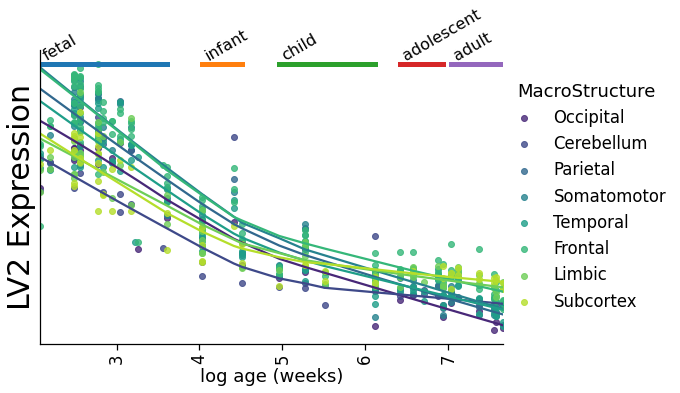

In [39]:
# C2
sns.set_context('notebook',font_scale=1.5)
g = sns.lmplot(x='log_age_weeks',y='C2_exp',aspect=1.5,
               data=gdf[(gdf.MacroStructure!='GangEm') &\
                        (gdf['C2_exp']<1000)],
           hue='MacroStructure',lowess=True,
               hue_order=['Occipital','Cerebellum','Parietal','Somatomotor',
                          'Temporal','Frontal','Limbic','Subcortex'],
              palette='viridis')
g.set_xticklabels(rotation=90)
for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[10,10],lw=5)
    #loc = xmin + (xmax-xmin)*.5
    plt.text(xmin,10,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.ylabel('LV2 Expression',fontsize=30)
plt.yticks([])
plt.xlabel('log age (weeks)')
#plt.savefig(os.path.join(fig_dir,'BS_Devel_C2.pdf'),bbox_inches='tight')

Text(0.5, 15.439999999999998, 'log age (weeks)')

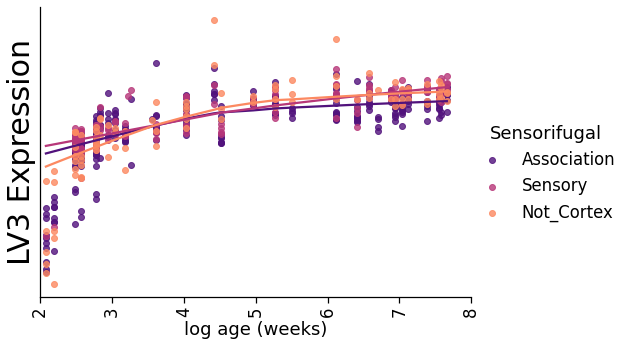

In [40]:
# c3
sns.set_context('notebook',font_scale=1.5)
g = sns.lmplot(x='log_age_weeks',y='C3_exp',aspect=1.5,
               data=gdf[gdf.C3_exp<400],
           hue='Sensorifugal',lowess=True,
              palette='magma')
g.set_xticklabels(rotation=90)
plt.ylabel('LV3 Expression',fontsize=30)
plt.yticks([])
plt.xlabel('log age (weeks)')

#plt.savefig(os.path.join(fig_dir,'BS_Devel_C3.pdf'),bbox_inches='tight')

# Comparison to adult

In NB3_PLS_ModelExploration, we generated component expression for Allen Brain Atlas data reduced to a low resolution (so as to better match the brainspan resolution). Here, we will load this data to compare regional expression of each component across the two datasets

#### Initialize some stuff

In [41]:
abac2 = pandas.read_csv('data/GCorr_BSComp_ABA_C2_data.csv',
                       index_col=0)
abac2.columns = ['ABA_mean','ABA_sem']
print('shared:',set(abac2.index) & set(gdf.MacroStructure2.unique()))
print('missing:',set(gdf.MacroStructure2.unique()) - set(abac2.index))

shared: {'Thalamus', 'Frontal', 'Cerebellum', 'Occipital', 'Temporal', 'Striatum', 'Parietal', 'Sensorimotor', 'Limbic'}
missing: {'GangEm'}


In [42]:
bsc2 = pandas.pivot_table(gdf,
                            #gdf[gdf.Age_Stage=='adult'],
                          values='C2_exp',
                             index='MacroStructure2',aggfunc=np.mean
                            )
for div in bsc2.index:
    sem = gdf[gdf.MacroStructure2==div]['C2_exp'].sem()
    bsc2.loc[div,'sem'] = sem
bsc2.columns = ['BS_mean','BS_sem']

In [43]:
c2_comp = pandas.concat([bsc2,abac2],axis=1,sort='True').dropna()
c2_comp.loc[:,'region'] = c2_comp.index
c2_comp.head()

,BS_mean,BS_sem,ABA_mean,ABA_sem,region
Cerebellum,2.078506,0.437169,-0.706893,0.019982,Cerebellum
Frontal,4.256409,0.291603,0.789432,0.031165,Frontal
Limbic,3.145265,0.326063,0.030956,0.039398,Limbic
Occipital,2.981103,0.534638,-1.655174,0.042085,Occipital
Parietal,3.602038,0.596066,-1.124981,0.031968,Parietal


#### Do cross-dataset comparison

In [44]:
# z-score data to account for standardized vs. non-standardize nature of the two datasets
for i in range(1,(n_comps+1)):
    vals = StandardScaler().fit_transform(gdf.loc[:,'C%s_exp'%i
                                                 ].values.reshape(-1,1)
                                         )[:,0]
    gdf.loc[:,'zC%s_exp'%i,] = vals

r = 0.981, p = 0.0


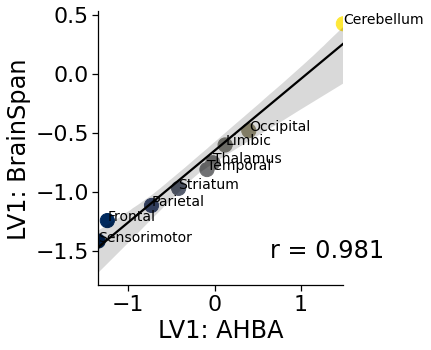

r = 0.954, p = 0.0


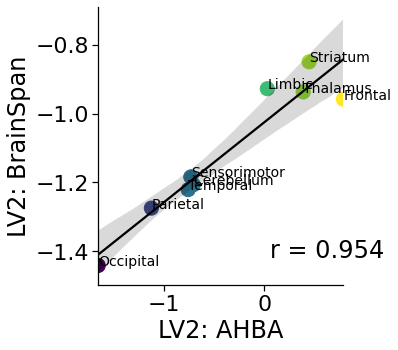

r = 0.914, p = 0.001


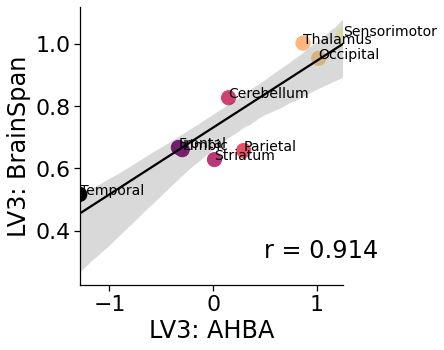

In [46]:
# note this analysis is only performed on the adult brainspan samples
sns.set_context('notebook',font_scale=2)
pals = ['cividis','viridis','magma']
for i in range(1,(n_comps+1)):
    # read allen data
    aba = pandas.read_csv('data/GCorr_BSComp_ABA_C%s_data_ROTATION.csv'%i,
                       index_col=0)
    aba.columns = ['ABA_mean','ABA_sem']
    # prep brainspan data
    bs = pandas.pivot_table(#gdf,
                            gdf[gdf.Age_Stage=='adult'],# just the adults!
                          values='zC%s_exp'%i,
                             index='MacroStructure2',aggfunc=np.mean
                            )
    # calculate SEM (I don't think i actually use this)
    for div in bs.index:
        sem = gdf[gdf.MacroStructure2==div]['zC%s_exp'%i].sem()
        bs.loc[div,'sem'] = sem
    bs.columns = ['BS_mean','BS_sem']
    # build comparison dataframe
    comp = pandas.concat([bs,aba],axis=1,sort='True').dropna()
    comp.loc[:,'region'] = c2_comp.index
    
    # colors
    cmap = sns.color_palette(pals[i-1],as_cmap=True)
    sg = comp.ABA_mean.values
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))
    
    # plot
    g=sns.lmplot(x='ABA_mean',y='BS_mean',data=comp,
           scatter_kws={'marker':'o','s':200,'color':cscale},
               line_kws={'color':'k'}
          )
    # stats
    r,p = stats.pearsonr(comp.ABA_mean.values,comp.BS_mean.values)
    print('r = %s, p = %s'%(round(r,3),round(p,3)))
    # decorate
    for it,div in enumerate(comp.sort_values('ABA_mean').index):
        x = comp.loc[div,'ABA_mean']
        y = comp.loc[div,'BS_mean']
        dist = len(div)*.02
        if it%2==0:
            plt.text(x, y,div,{'size':14})
        else:
            plt.text(x, y,div,{'size':14},
                     )
    plt.xlabel('LV%s: AHBA'%i)
    plt.ylabel('LV%s: BrainSpan'%i)
    plt.text(0.7,0.1,'r = %s'%round(r,3),transform=g.ax.transAxes)
    #plt.xlim(-.45,.45)
    #plt.savefig(os.path.join(fig_dir,'BrSp_Repl_C%s_ROTATED.pdf'%i), bbox_inches='tight')
    plt.show()

# Individual subject matching

We can do the same analysis above, except this time, we can compare regional component expression of individual subjects to those of Allen Brain Atlas. That way, we can track how individual variables (like age) related to how well the components replicate.

In [47]:
# create individual dfs for each component
gpdfs = {}
for i in range(1,(n_comps+1)):
    gpdf = gdf[['donor_id','C%s_exp'%i,'MacroStructure2']
                  ].set_index(['donor_id'],append=True
                             ).pivot_table(index='donor_id',
                                           columns='MacroStructure2',
                                           values='C%s_exp'%i)
    gpdf.drop('GangEm',axis=1,inplace=True)
    for ind,row in gpdf.iterrows():
        n_valid = len([x for x in row.values if pandas.notnull(x)])
        gpdf.loc[ind,'n_valid'] = n_valid
    gpdfs.update({i: gpdf})

In [48]:
# example. We see there is missing data for different donors
print(gpdfs[1].shape)
gpdfs[1].head()

(42, 10)


MacroStructure2,Cerebellum,Frontal,Limbic,Occipital,Parietal,Sensorimotor,Striatum,Temporal,Thalamus,n_valid
donor_id,,,,,,,,,,
12287,NaN,2.051860,NaN,2.302433,1.958748,NaN,1.127167,2.082692,1.586198,6.0
12288,2.535296,1.985555,0.969260,2.563760,2.041047,1.755956,1.180680,2.535793,1.967091,9.0
12289,0.766107,-0.463291,0.317132,0.243820,-0.210094,-0.763943,NaN,-0.024659,NaN,7.0
12290,1.473851,-0.296736,0.312765,0.572651,-0.111098,-0.517832,0.058789,0.117119,-0.038090,9.0
12295,2.713052,1.580476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [49]:
# how many people are missing how much data?
gpdfs[1].n_valid.value_counts()

9.0    18
8.0     9
7.0     6
6.0     3
4.0     2
2.0     2
3.0     1
1.0     1
Name: n_valid, dtype: int64

In [50]:
# now we'll create similarity calculations for each subject, for each component.
# we'll only use subjects that have data for 6+ brain regions

# for each component
for c in range(1,(n_comps+1)):
    # prep data
    cdf = gpdfs[c]
    aba = pandas.read_csv('data/GCorr_BSComp_ABA_C%s_data.csv'%c,
                       index_col=0)
    aba.columns = ['ABA_mean','ABA_sem']
    aba = aba.loc[cdf.columns[:-1]]
    # for each subject
    for i,row in cdf.iterrows():
        forcorr = pandas.DataFrame(aba,copy=True)
        # if subject has 6+ regions with data
        if row['n_valid'] > 5:
            # find similarity to Allen expression
            forcorr.loc[:,'gvec'] = row.values[:-1]
            forcorr.dropna(inplace=True)
            r = stats.pearsonr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            rho = stats.spearmanr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            # store values
            cdf.loc[i,'C%s_r'%c] = r
            cdf.loc[i,'C%s_rho'%c] = rho

In [51]:
# build a summary dataframe at the indexed by subjects

cols = ['column_num', 'donor_id', 'donor_name', 'age', 
        'gender','structure_id', 'structure_acronym', 'structure_name',
       'Age_Stage', 'Age_Epoch', 'Age_Period',
       'MacroStructure', 'MacroStructure2', 'NT_Segment', 'Sensorifugal',
       'age_level', 'age_in_months',
       'log_age_months','age_in_weeks','log_age_weeks']
subsum = pandas.DataFrame(gpdfs[1].index)
for col in cols:
    subsum.loc[:,col] = gdf.groupby('donor_id')[col].first().values
for c in range(1,(n_comps+1)):
    subsum.loc[:,'C%s_r'%c] = gpdfs[c].loc[:,'C%s_r'%c].values
    subsum.loc[:,'C%s_rho'%c] = gpdfs[c].loc[:,'C%s_rho'%c].values
    subsum.loc[:,'n_valid'] = gpdfs[c].loc[:,'n_valid'].values

r=0.745, p=0.0


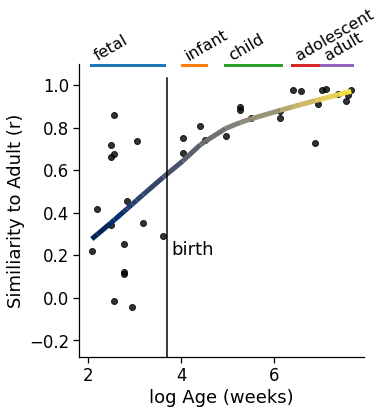

r=0.797, p=0.0


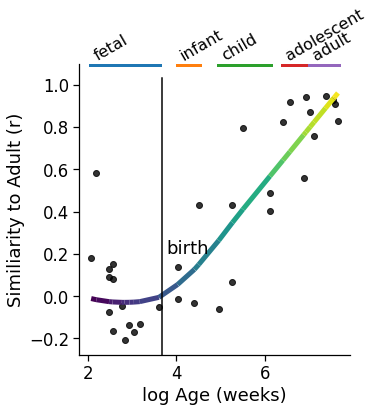

r=0.612, p=0.0001


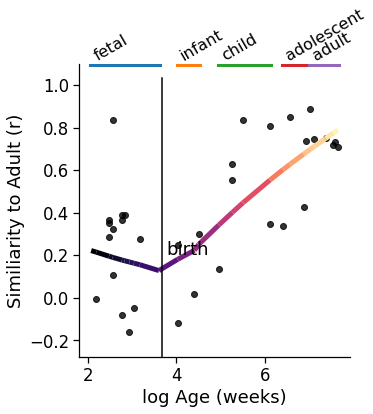

In [53]:
# plot similarity to Allen Brain (i.e. adult data) against age for each component 

sns.set_context('notebook',font_scale=1.5)
# for each component
for c in range(1,(n_comps+1)):
    # plot
    g=sns.lmplot(x='log_age_weeks',y='C%s_r'%c,
                lowess=True,
                 scatter_kws={'color':'k'},
               data=subsum)
    plotr = pandas.DataFrame(subsum[['C%s_r'%c,'age_level']],
                            copy=True).dropna()
    # get stats
    r,p=stats.pearsonr(plotr['C%s_r'%c].values,
                      plotr.age_level.values)
    print('r=%s, p=%s'%(round(r,3),round(p,4)))
    
    # make line purty
    x, y = g.ax.get_lines()[0].get_data()
    segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
    norm = plt.Normalize(x.min(), x.max())
    lc = LineCollection(segments, cmap=pals[c-1], norm=norm)
    lc.set_array(x[:-1])
    lc.set_linewidth(2)
    g.ax.get_lines()[0].remove()
    line = g.ax.add_collection(lc)
    plt.setp(line,linewidth=5)
    
    # decorate so age stage is indicated
    for stage in gdf.Age_Stage.unique():
        levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
        xmin = np.min(levels)
        xmax = np.max(levels)
        plt.plot([xmin,xmax],[1.1,1.1],lw=5)
        #loc = xmin + (xmax-xmin)*.5
        plt.text(xmin,1.1,stage,fontsize=16,ha='left',
                 va='bottom',rotation=30)
    
    # further decorate
    plt.ylabel('Similiarity to Adult (r)')
    plt.xlabel('log Age (weeks)',)#fontsize=30)
    plt.ylim(-0.28,1.1)
    ymin = subsum['C%s_r'%c].min() - 0.1
    plt.axvline(np.log(40),ymax=0.95,c='k')
    plt.text(np.log(40)+0.1,0.2,'birth')
    #plt.savefig(os.path.join(fig_dir,'BrSp_CompR_C%s.pdf'%c), bbox_inches='tight')
    plt.show()
    



In [55]:
# Let's plot all those lines on one plot
devplot = pandas.DataFrame(pandas.concat([subsum.C1_r,
                                          subsum.C2_r,
                                          subsum.C3_r]))
devplot.columns = ['r']
n = len(subsum)
devplot.loc[:,'Component'] = ['1']*n + ['2']*n + ['3']*n
devplot.loc[:,'age_level'] = subsum.age_level.tolist() * 3
devplot.loc[:,'age_stage'] = subsum.Age_Stage.tolist() * 3
devplot.loc[:,'age_in_months'] = subsum.age_in_months.tolist() * 3
devplot.loc[:,'log_age_months'] = subsum.log_age_months.tolist() * 3
devplot.loc[:,'age_in_weeks'] = subsum.age_in_weeks.tolist() * 3
devplot.loc[:,'log_age_weeks'] = subsum.log_age_weeks.tolist() * 3

Text(0.5, 15.439999999999998, 'log Age (weeks)')

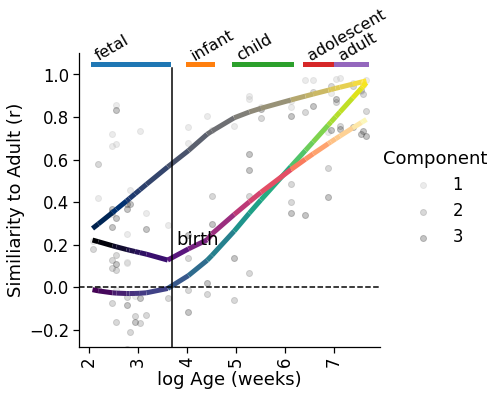

In [56]:
g=sns.lmplot(x='log_age_weeks',y='r',hue='Component',lowess=True,aspect=1.1,
             hue_order=['1','2','3'],palette='binary',
               data=devplot,scatter_kws={'alpha':0.3})
g.ax.set_ylim(-0.3,1.08)
g.set_xticklabels(rotation=90)
for i in range(3):
    # make line purty
    x, y = g.ax.get_lines()[i].get_data()
    segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
    norm = plt.Normalize(x.min(), x.max())
    lc = LineCollection(segments, cmap=pals[i], norm=norm)
    lc.set_array(x[:-1])
    lc.set_linewidth(2)
    line = g.ax.add_collection(lc)
    plt.setp(line,linewidth=5)
for i in range(3):
    g.ax.get_lines()[0].remove()

for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    #loc = xmin + (xmax-xmin)*.5
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,ls='--',c='k')
plt.axvline(np.log(40),ymax=0.95,c='k')
plt.text(np.log(40)+0.1,0.2,'birth')
plt.ylim(-0.28,1.1)
plt.ylabel('Similiarity to Adult (r)')
plt.xlabel('log Age (weeks)')
#plt.savefig(os.path.join(fig_dir,'BrSp_CompR_overlay.pdf'),bbox_inches='tight')

# Save progress
(for other notebooks)

In [58]:
gdf.to_csv('data/brainspan.csv')
subsum.to_csv('data/subsum.csv')

# Identifying candidate early gradient genes
We were somewhat surprised to see little molecular trace of these gradients in early development (especially for LV2 and LV3). This went somewhat against our hypothesis that these are truly early developmental gradients. It also was at odds with some of the bioinformatics analyses later that suggest many of the genes contained in these gradients are early developmental genes. So, we hypothesized that there would be at least *some* genes detectable in the adult gradients that would already show a gradient-like distribution in early (prenatal) brain development. This analysis is meant to identify those, and we later validate them in the PsychENCODE dataset

First, get a list of all "gradient-associated genes". These are genes within the top 5% (adjusted for multiple comparisons) of each gradient, and sampling equally from each gradient tail. This is the same gene set we use for enrichment analyses in a later notebook

In [63]:
alltopgenes = []
for c in range(1,4):
    # get the top contributing genes from each component
    perc = 0.025 / 3 # 5% / two tails = 2.5% / 3 PLS components = perc
    thresh = int(round(all_comps.shape[0] * perc)) 
    genes = all_comps.sort_values('C%s'%c).dropna().gene_symbol.tolist()[:thresh]
    genes += all_comps.sort_values('C%s'%c).dropna().gene_symbol.tolist()[-thresh:]
    # and get a big list of all of them
    alltopgenes += genes

For each of these top genes, across every tissue sample, we will see how correlated the gene's regional expression in that tissue sample is to the regional expression of that gene in the adult (AHBA) dataset. 

**Note:** This code is somewhat time-consuming to run

In [64]:
# for each LV
for c in range(1,4):
    print('_____WORKING ON C%s_____'%c)
    # Get a tiny C2 dataframe
    jnk = pandas.DataFrame(gxp.T,copy=True)
    for col in ['donor_id','MacroStructure2','C%s_exp'%c]:
        jnk.loc[:,col] = gdf[col].values

    # load Allen Brain Atlas data
    aba = pandas.read_csv('data/GCorr_BSComp_ABA_C%s_data_ROTATION.csv'%c,
                   index_col=0)
    aba.columns = ['ABA_mean','ABA_sem']

    # create a summary dataframe and add columns
    subsum = pandas.DataFrame(index=gdf.donor_id.unique())
    for col in cols:
        subsum.loc[:,col] = gdf.groupby('donor_id')[col].first().loc[subsum.index].values

    # iterage through all genes
    for it,gene in enumerate(gxp.index):
        # keep track
        if it % 1000 == 0:
            print('working on %s of %s'%((it+1),len(gxp)))
        # IF DOING ONLY TOP GENES
        if gene not in np.unique(alltopgenes): continue 
        # In case you want to stop and pick up from where you left off
        if '%s_r'%gene in subsum.columns: continue 
        # make a subject x expression dataframe for the gene
        gpdf = jnk[['donor_id',gene,'MacroStructure2']
                      ].set_index(['donor_id'],append=True
                                 ).pivot_table(index='donor_id',
                                               columns='MacroStructure2',
                                               values=gene).loc[subsum.index]
        gpdf.drop('GangEm',axis=1,inplace=True)
        
        # count how many instances (i.e. regions) have valid (not NaN) entries
        for ind,row in gpdf.iterrows():
            n_valid = len([x for x in row.values if pandas.notnull(x)])
            gpdf.loc[ind,'n_valid'] = n_valid
        aba = aba.loc[gpdf.columns[:-1]]

        fail = False
        # iterate through the subjects
        for i,row in gpdf.iterrows():
            # find out correlation of gene with AHBA C2 for each subject
            forcorr = pandas.DataFrame(aba,copy=True)
            if row['n_valid'] > 5: # only if 6+ valid entries
                forcorr.loc[:,'gvec'] = row.values[:-1]
                forcorr.dropna(inplace=True)
                if all(forcorr['gvec'].values == forcorr['gvec'].values[0]): 
                    fail = True
                    continue
                r = stats.pearsonr(forcorr['ABA_mean'].values,
                                  forcorr['gvec'].values)[0]
                # get non-parametric in case reviewer asks
                rho = stats.spearmanr(forcorr['ABA_mean'].values,
                                  forcorr['gvec'].values)[0]
                gpdf.loc[i,'%s_r'%gene] = r
                gpdf.loc[i,'%s_rho'%gene] = rho
        # store per gene information for each subject -- r, rho and n_valid
        if fail == True: continue
        subsum.loc[:,'%s_r'%gene] = gpdf.loc[subsum.index,'%s_r'%gene].values
        subsum.loc[:,'%s_rho'%gene] = gpdf.loc[subsum.index,'%s_rho'%gene].values
        subsum.loc[:,'n_valid'] = gpdf.loc[subsum.index,'n_valid'].values
    
    # save and move to the next LV
    subsum.to_csv('data/BioInf_rvals_C%s_rotated.csv'%c)

_____WORKING ON C1_____
working on 1 of 13786
working on 1001 of 13786
working on 2001 of 13786
working on 3001 of 13786
working on 4001 of 13786
working on 5001 of 13786
working on 6001 of 13786
working on 7001 of 13786
working on 8001 of 13786
working on 9001 of 13786
working on 10001 of 13786
working on 11001 of 13786
working on 12001 of 13786
working on 13001 of 13786
_____WORKING ON C2_____
working on 1 of 13786
working on 1001 of 13786
working on 2001 of 13786
working on 3001 of 13786
working on 4001 of 13786
working on 5001 of 13786
working on 6001 of 13786
working on 7001 of 13786
working on 8001 of 13786
working on 9001 of 13786
working on 10001 of 13786
working on 11001 of 13786
working on 12001 of 13786
working on 13001 of 13786
_____WORKING ON C3_____
working on 1 of 13786
working on 1001 of 13786
working on 2001 of 13786
working on 3001 of 13786
working on 4001 of 13786
working on 5001 of 13786
working on 6001 of 13786
working on 7001 of 13786
working on 8001 of 13786
work

We'll need to do this component by component so... 
### C1

In [65]:
subsum = pandas.read_csv('data/BioInf_rvals_C1_rotated.csv',index_col=0)

In [66]:
# Get the significant C1 genes
c=1
perc = 0.025 / 3
thresh = int(round(all_comps.shape[0] * perc))
genes = all_comps.sort_values('C%s'%c).dropna().gene_symbol.tolist()[:thresh]
genes += all_comps.sort_values('C%s'%c).dropna().gene_symbol.tolist()[-thresh:]
topgenes = pandas.DataFrame(genes)
topgenes.columns = ['C1']

In [67]:
# recreate subject summary file
cols = ['donor_id', 'donor_name', 'age', 
        'gender','structure_id', 'structure_acronym', 'structure_name',
       'Age_Stage', 'Age_Epoch', 'Age_Period',
       'MacroStructure', 'MacroStructure2', 'NT_Segment', 'Sensorifugal',
       'age_level','age_in_months',
       'log_age_months','age_in_weeks','log_age_weeks']
for col in cols:
    subsum.loc[:,col] = gdf.groupby('donor_id')[col].first().loc[subsum.index].values

In [68]:
# create a dataframe of top C1 gene trajectories
c2ss = pandas.DataFrame(subsum[[x+'_r' for x in topgenes.C1.values if x+'_r' in subsum.columns]
                              ].dropna(),copy=True)

# get rid of gene and samples for which we don't have full data for everyone
c2ss.drop([x for x in c2ss.index if all(~pandas.notnull(c2ss.loc[x]))],axis=0,inplace=True)
c2ss.drop([x for x in c2ss.columns if any(~pandas.notnull(c2ss.loc[:,x]))],axis=1,inplace=True)

Next, we will cluster the data. This will find us clusters of genes that have similar trajectories of regional similarity to adult LV expression across development. We'll use silhouette scores to find "peaks" that will help us define clustering solutions to inspect

In [71]:
csol = pandas.DataFrame()
for i,k in enumerate(range(2,50)):
    #print('working on k =',k)
    d = c2ss.T.values
    cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', 
                                  linkage='ward')
    cluster.fit_predict(d)
    csol.loc[i,'k'] = k
    csol.loc[i,'sil_score'] = silhouette_score(d,cluster.labels_,random_state=123)
    csol.loc[i,'ch_score'] = calinski_harabasz_score(d,cluster.labels_)

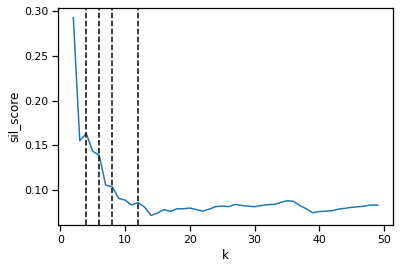

In [72]:
sns.lineplot(x='k',y='sil_score',data=csol)
peaks = [4,6,8,12]
for peak in peaks:
    plt.axvline(peak,ls='--',c='k')

We inspected each peak solution, starting from the lowest k, until we found a cluster emerging with a profile similar to what we were expecting: high similarity to LV1 throughout development. We found one at k = 12

<AxesSubplot:>

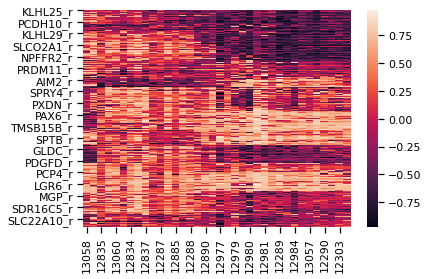

In [73]:
# cluster once more based on peak
cluster = AgglomerativeClustering(n_clusters=12, affinity='euclidean', 
                                  linkage='ward')
cluster.fit_predict(c2ss.T.values)
# sort data by cluster labels and plot
data = pandas.DataFrame(c2ss.T,copy=True)
data.loc[:,'labels'] = cluster.labels_
sorted_ind = [x for x in subsum.sort_values('log_age_weeks').index if x in data.columns]
sns.heatmap(data.sort_values('labels')[sorted_ind])

In [74]:
# store this for the next notebook
c2ss.to_csv('data/BSDevGens_C1_ss_12clus.csv')

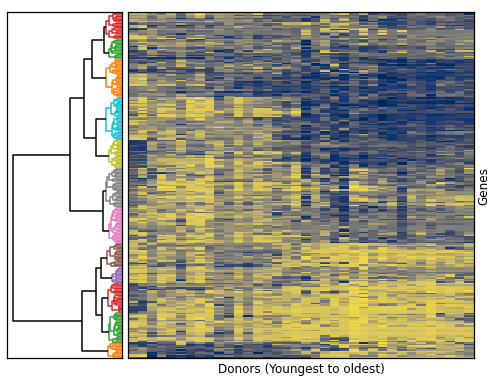

In [75]:
# plot the clustering solution for the manuscript

# Now make a version for visualization in the paper
import scipy.cluster.hierarchy as shc

# get the dendogram for the clustering solution
link = shc.linkage(c2ss.T.values, method='ward')
#dend = shc.dendrogram(link)

# get an index ordering that sorts by age
sorder = [x for x in subsum.sort_values('log_age_weeks').donor_id.values if x in c2ss.T.columns]

# define data
D = pandas.DataFrame(c2ss.T[sorder], copy=True)
D = D.values

# create dendogram
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_axes([0.09, 0.1, 0.2, 0.6])
Y = link
shc.set_link_color_palette(None)
Z1 = shc.dendrogram(Y, orientation='left',color_threshold=6,above_threshold_color='black',)
ax1.set_xticks([])
ax1.set_yticks([])

# main heat-map
axmatrix = fig.add_axes([0.3, 0.1, 0.6, 0.6])
idx1 = Z1['leaves']
D = D[idx1, :]
# the actual heat-map
im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap="cividis",vmin=-1,vmax=1)

# decorate
axmatrix.set_xticks([])
axmatrix.set_yticks([])
axmatrix.yaxis.set_label_position('right')
plt.xlabel('Donors (Youngest to oldest)',)
plt.ylabel('Genes')

#plt.savefig(os.path.join(fig_dir,'EGenes_DendoC1_4clus.pdf'),bbox_inches='tight')
plt.show()

In [76]:
# Let's create a datafrome to allow us to plot this in a more intuitive way

cplots = data.groupby('labels').mean().T
cplots.columns = ['cluster%s'%x for x in cplots.columns]
for col in subsum.columns[:20]:
    cplots.loc[:,col] = subsum.loc[c2ss.index,col].values
cplots.head()

,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,...,Age_Period,MacroStructure,MacroStructure2,NT_Segment,Sensorifugal,age_level,age_in_months,log_age_months,age_in_weeks,log_age_weeks
13058,0.056134,0.319605,0.140397,-0.035286,-0.173570,-0.330594,0.429760,-0.537206,0.585112,0.458994,...,p2,Occipital,Occipital,Tele,Association,0,1.839080,0.609266,8.0,2.079442
12833,0.153570,0.490703,0.218691,-0.008314,0.160093,-0.292014,0.410751,-0.489052,0.644366,0.507671,...,p2,Frontal,Frontal,Tele,Association,1,2.068966,0.727049,9.0,2.197225
12835,-0.071293,0.180757,0.065193,-0.521604,0.082317,0.194603,0.088788,0.193391,0.223098,0.140186,...,p3,Limbic,Limbic,Tele,Association,2,2.758621,1.014731,12.0,2.484907
12960,-0.019011,0.375712,0.130570,-0.297983,0.496757,0.281168,0.229346,0.089666,0.611336,0.563474,...,p3,Temporal,Temporal,Tele,Association,2,2.758621,1.014731,12.0,2.484907
13060,-0.107446,0.409937,0.086346,-0.482986,0.409204,0.286580,0.173532,0.249074,0.523357,0.530825,...,p3,Limbic,Limbic,Tele,Association,2,2.758621,1.014731,12.0,2.484907


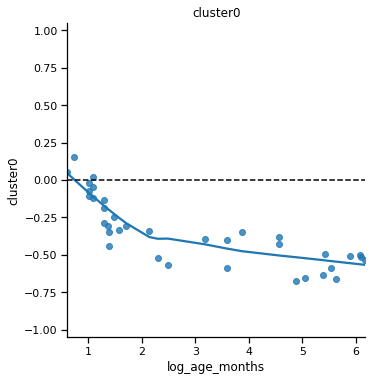

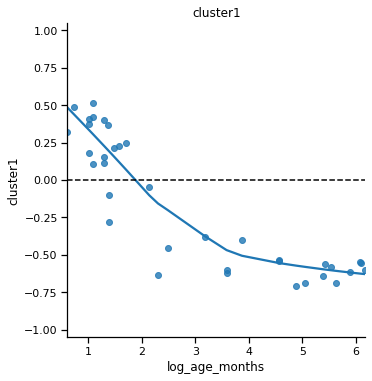

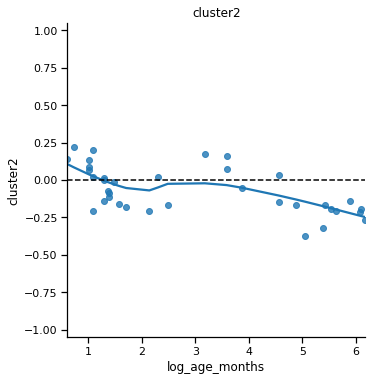

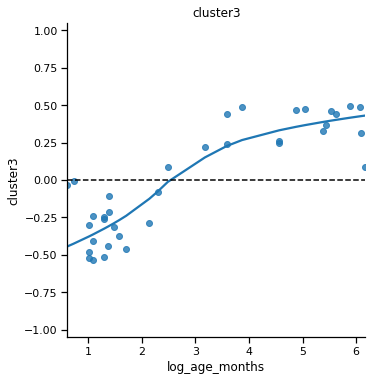

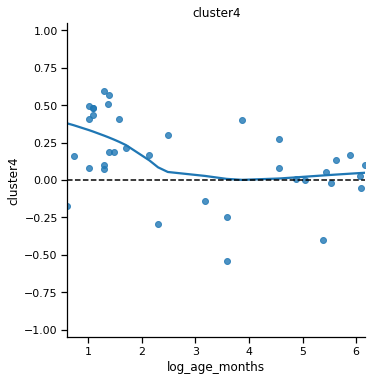

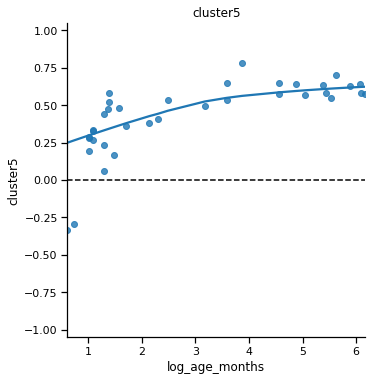

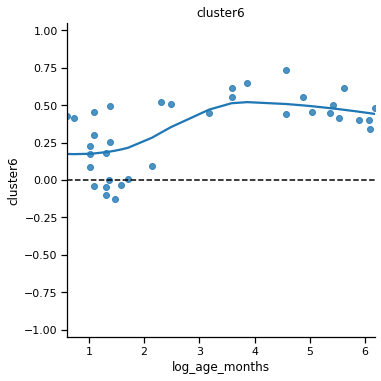

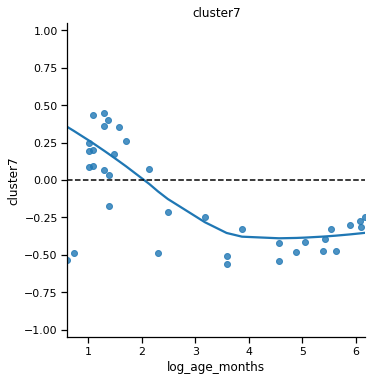

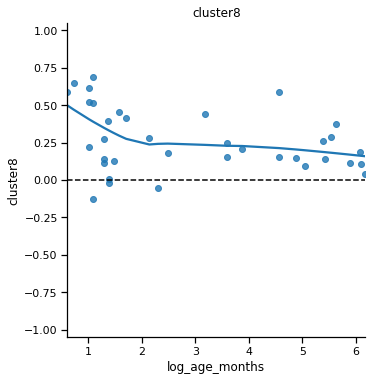

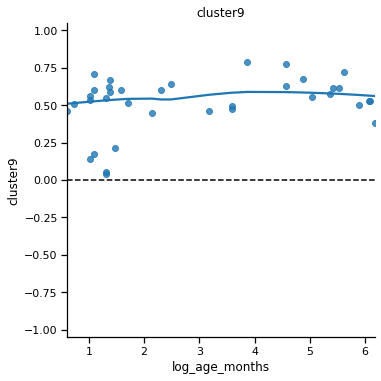

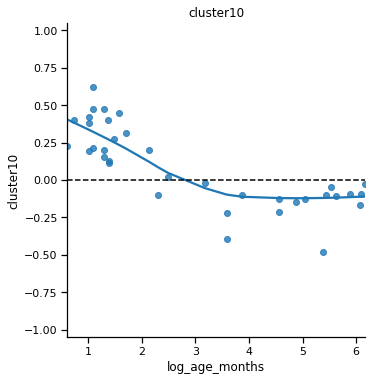

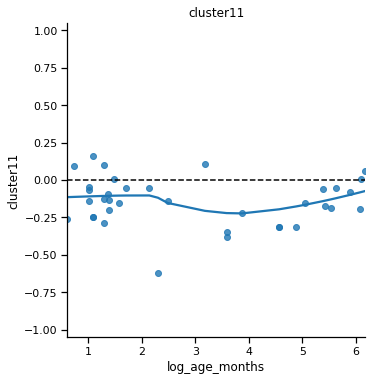

In [77]:
# making plotting dataframe
cplots.loc[:,'ind'] = cplots.index
tall = pandas.melt(cplots,id_vars='ind',
                   value_vars=[x for x in cplots.columns if 'cluster' in x])
tall.loc[:,'log_age_weeks'] = cplots.log_age_weeks.tolist() * len(tall.variable.unique())
# for each cluster
for cluster in [x for x in cplots.columns if 'cluster' in x]:
    # plot expression over log age
    g=sns.lmplot(x='log_age_months',y=cluster,
            #hue='gender',
            lowess=True,
             #scatter_kws={'color':'k'},
           data=cplots)
    # decorate
    plt.ylim(-1.05,1.05)
    plt.axhline(0,ls='--',c='k')
    plt.title(cluster)
    plt.show()

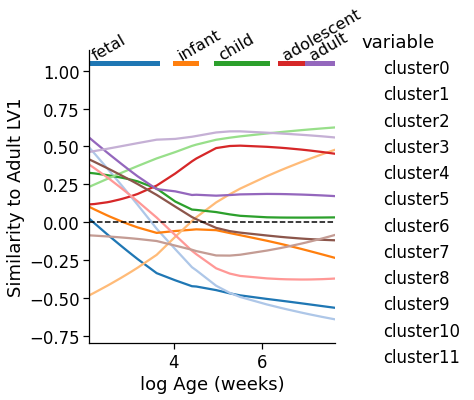

In [78]:
# Plot them all at once

# plot the trajectory of all clusters


sns.set_context('notebook',font_scale=1.5)
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',palette='tab20',
             #palette=['gray']*len(tall.variable.unique()),#palette=colors,
             #legend=None,
             data=tall)
plt.ylabel('Similarity to Adult LV1')
plt.xlabel('log Age (weeks)')

for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
#plt.savefig(os.path.join(fig_dir,'EGenes_C1_ClusterTimelines.pdf'),bbox_inches='tight')

In the previous plots, we can see many times of trajectories. We can see some that start out very similar to adult LV1 expression but then stop doing so over development (probably because of decreased expression). These are often called "falling" genes. We also see some that become more similar to LV expression over development, often called "rising" genes. Note also that negative r-values are also indices of similarity, because they are simply genes in the other side of the tail. There are even some genes that seem to "switch" tails over development. 

However, there is one cluster with a unique trajectory, in light purple above. It has a high regional similarity to LV1 at early develppment, and stays that way throughout. That's our target. Cluster 9. Let's get a look at the individual trajectory of each gene falling into that cluster

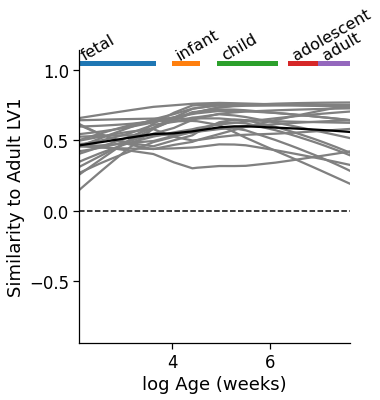

In [79]:
# plot the trajectory of all genes in cluster 5

c5plots = pandas.DataFrame(data[data.labels==9].T,copy=True)
c5plots.drop('labels',inplace=True)
c5plots.loc[:,'ind'] = range(len(c5plots))
c5plots.loc[:,'log_age_weeks'] = subsum.loc[c5plots.index,'log_age_weeks'].values
gtall = pandas.melt(c5plots,id_vars='ind',
                   value_vars=[x for x in c5plots.columns if '_r' in x])
gtall.loc[:,'log_age_weeks'] = c5plots.log_age_weeks.tolist() * len(gtall.variable.unique())

sns.set_context('notebook',font_scale=1.5)
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',
             palette=['gray']*len(tall.variable.unique()),
             legend=None,
             data=gtall)
sns.regplot(x=cplots.log_age_weeks.values,y=cplots.cluster9.values,color='black',
           marker='',lowess=True)
plt.ylabel('Similarity to Adult LV1')
plt.xlabel('log Age (weeks)')

for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
# plt.savefig(os.path.join(fig_dir,'EGenes_C1_ClusterTimelines_12Clus_9.pdf'),
#             bbox_inches='tight')

In [81]:
# meet the genes
[x.split('_')[0] for x in c5plots.columns if '_r' in x]

['GDF10',
 'DENND2D',
 'SPON2',
 'LAMB1',
 'TSPAN33',
 'SP5',
 'ZIC1',
 'VIT',
 'SPTBN5',
 'ADAMTS2',
 'PYDC1',
 'GRM4',
 'HLA-J',
 'SHF',
 'TLL1',
 'C14orf132',
 'LIMK2',
 'LGR6',
 'CCDC88B',
 'TP53AIP1',
 'IGDCC3']

This a pretty posthoc approach, so we want to be sure that these genes replicate in another dataset. Therefore, let's save the clustering data

In [82]:
c1labs = pandas.concat([pandas.Series([x.split('_')[0] for x in data.index]),
               pandas.Series(data.labels.values)],
              axis=1)
c1labs.columns = ['Gene','Cluster']
c1labs.to_csv('data/C1_devclusters_12clus.csv')

### C2
Now we repeat for C2. Since it's all kind of the same code, I'll just get on with it

In [84]:
subsum = pandas.read_csv('data/BioInf_rvals_C2_rotated.csv',index_col=0)

In [86]:
# Get the significant C2 genes
c=2
perc = 0.025 / 3
thresh = int(round(all_comps.shape[0] * perc))
genes = all_comps.sort_values('C%s'%c).dropna().gene_symbol.tolist()[:thresh]
genes += all_comps.sort_values('C%s'%c).dropna().gene_symbol.tolist()[-thresh:]
topgenes = pandas.DataFrame(genes)
topgenes.columns = ['C2']

In [87]:
cols = ['donor_id', 'donor_name', 'age', 
        'gender','structure_id', 'structure_acronym', 'structure_name',
       'Age_Stage', 'Age_Epoch', 'Age_Period',
       'MacroStructure', 'MacroStructure2', 'NT_Segment', 'Sensorifugal',
       'age_level','age_in_months',
       'log_age_months','age_in_weeks','log_age_weeks']
for col in cols:
    subsum.loc[:,col] = gdf.groupby('donor_id')[col].first().loc[subsum.index].values

In [88]:
c2ss = pandas.DataFrame(subsum[[x+'_r' for x in topgenes.C2.values if x+'_r' in subsum.columns]
                              ].dropna(),copy=True)
c2ss.drop([x for x in c2ss.index if all(~pandas.notnull(c2ss.loc[x]))],axis=0,inplace=True)
c2ss.drop([x for x in c2ss.columns if any(~pandas.notnull(c2ss.loc[:,x]))],axis=1,inplace=True)

In [89]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.cluster import AgglomerativeClustering
csol = pandas.DataFrame()
for i,k in enumerate(range(2,50)):
    #print('working on k =',k)
    d = c2ss.T.values
    cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', 
                                  linkage='ward')
    cluster.fit_predict(d)
    csol.loc[i,'k'] = k
    csol.loc[i,'sil_score'] = silhouette_score(d,cluster.labels_,random_state=123)
    csol.loc[i,'ch_score'] = calinski_harabasz_score(d,cluster.labels_)

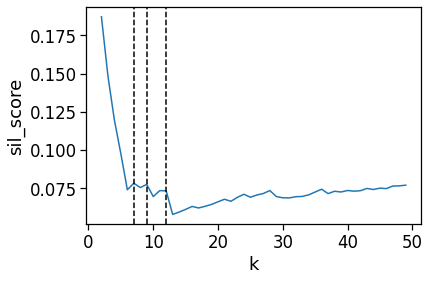

In [90]:
sns.lineplot(x='k',y='sil_score',data=csol)
peaks = [7,9,12]
for peak in peaks:
    plt.axvline(peak,ls='--',c='k')

<AxesSubplot:>

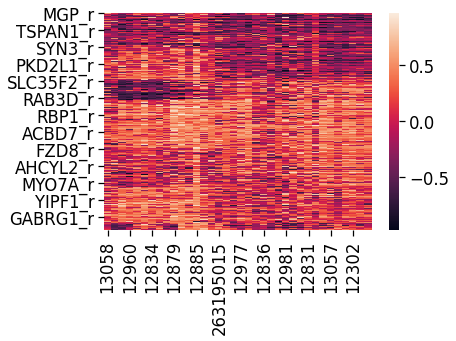

In [91]:
# cluster once more based on peak
cluster = AgglomerativeClustering(n_clusters=7, affinity='euclidean', 
                                  linkage='ward')
cluster.fit_predict(c2ss.T.values)
# sort data by cluster labels and plot
data = pandas.DataFrame(c2ss.T,copy=True)
data.loc[:,'labels'] = cluster.labels_
sorted_ind = [x for x in subsum.sort_values('log_age_weeks').index if x in data.columns]
sns.heatmap(data.sort_values('labels')[sorted_ind])

In [92]:
c2ss.to_csv('data/BSDevGens_C2_ss_7clus.csv')

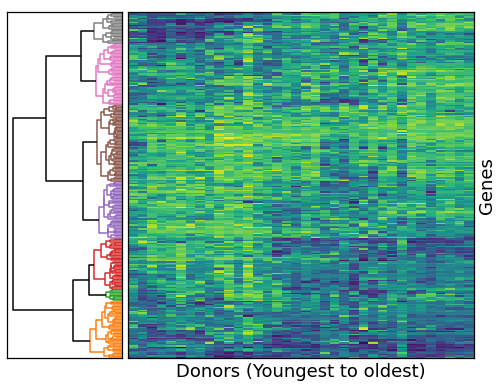

In [93]:
# Now make a version for visualization in the paper
import scipy.cluster.hierarchy as shc

# get the dendogram for the clustering solution
link = shc.linkage(c2ss.T.values, method='ward')
#dend = shc.dendrogram(link)

# get an index ordering that sorts by age
sorder = [x for x in subsum.sort_values('log_age_weeks').donor_id.values if x in c2ss.T.columns]

# define data
D = pandas.DataFrame(c2ss.T[sorder], copy=True)
D = D.values

# create dendogram
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_axes([0.09, 0.1, 0.2, 0.6])
Y = link
shc.set_link_color_palette(None)
Z1 = shc.dendrogram(Y, orientation='left',color_threshold=6.5,above_threshold_color='black',)
ax1.set_xticks([])
ax1.set_yticks([])

# main heat-map
axmatrix = fig.add_axes([0.3, 0.1, 0.6, 0.6])
idx1 = Z1['leaves']
D = D[idx1, :]
# the actual heat-map
im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap="viridis",vmin=-1,vmax=1)

# decorate
axmatrix.set_xticks([])
axmatrix.set_yticks([])
axmatrix.yaxis.set_label_position('right')
plt.xlabel('Donors (Youngest to oldest)',)
plt.ylabel('Genes')

#plt.savefig(os.path.join(fig_dir,'EGenes_DendoC2_7clus.pdf'),bbox_inches='tight')
plt.show()

In [94]:
cplots = data.groupby('labels').mean().T
cplots.columns = ['cluster%s'%x for x in cplots.columns]
for col in subsum.columns[:20]:
    cplots.loc[:,col] = subsum.loc[c2ss.index,col].values
cplots.head()

,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,column_num,donor_id,donor_name,...,Age_Period,MacroStructure,MacroStructure2,NT_Segment,Sensorifugal,age_level,age_in_months,log_age_months,age_in_weeks,log_age_weeks
13058,-0.084519,0.024197,-0.222004,0.169684,0.027162,0.170094,-0.047282,1,13058,H376.IIA.51,...,p2,Occipital,Occipital,Tele,Association,0,1.839080,0.609266,8.0,2.079442
12833,-0.176794,0.006661,-0.250638,0.128818,-0.021786,0.207194,-0.510602,17,12833,H376.IIA.50,...,p2,Frontal,Frontal,Tele,Association,1,2.068966,0.727049,9.0,2.197225
12835,-0.349043,0.229076,-0.624491,0.352181,-0.085522,0.428138,-0.380977,31,12835,H376.IIB.50,...,p3,Limbic,Limbic,Tele,Association,2,2.758621,1.014731,12.0,2.484907
12960,-0.247817,0.159012,-0.563803,0.254141,-0.086976,0.339731,-0.224025,46,12960,H376.IIB.51,...,p3,Temporal,Temporal,Tele,Association,2,2.758621,1.014731,12.0,2.484907
13060,-0.090620,0.180365,-0.356205,0.357387,0.107326,0.400679,0.102176,61,13060,H376.IIB.52,...,p3,Limbic,Limbic,Tele,Association,2,2.758621,1.014731,12.0,2.484907


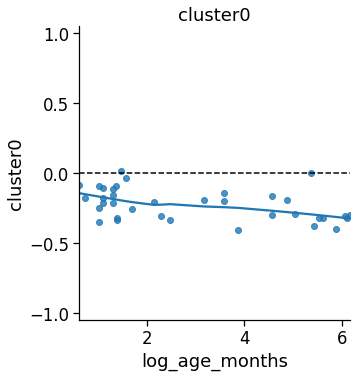

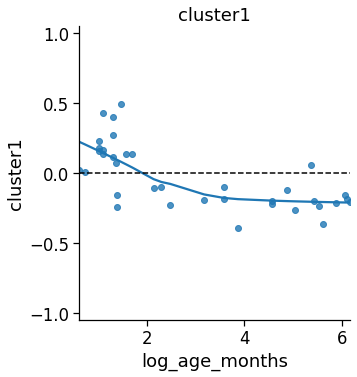

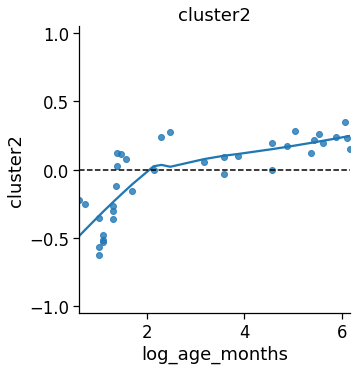

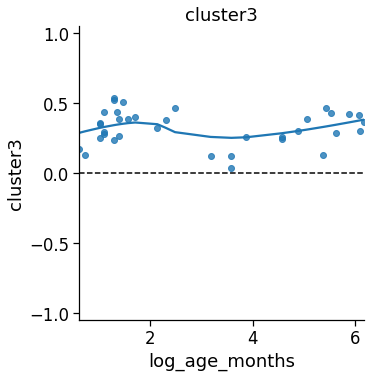

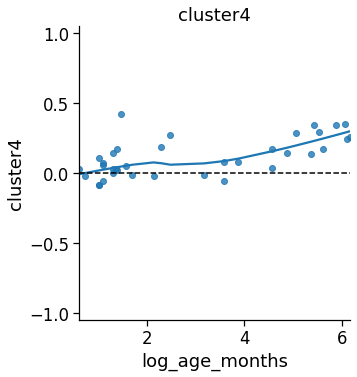

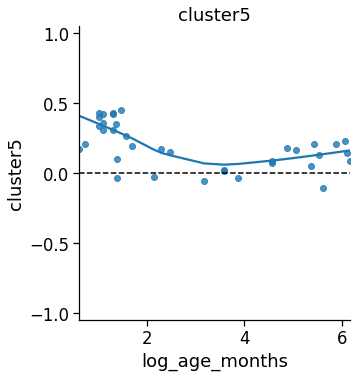

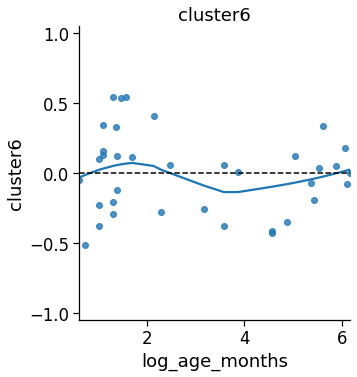

In [95]:
# making plotting dataframe
cplots.loc[:,'ind'] = cplots.index
tall = pandas.melt(cplots,id_vars='ind',
                   value_vars=[x for x in cplots.columns if 'cluster' in x])
tall.loc[:,'log_age_weeks'] = cplots.log_age_weeks.tolist() * len(tall.variable.unique())
# for each cluster
for cluster in [x for x in cplots.columns if 'cluster' in x]:
    # plot expression over log age
    g=sns.lmplot(x='log_age_months',y=cluster,
            #hue='gender',
            lowess=True,
             #scatter_kws={'color':'k'},
           data=cplots)
    # decorate
    plt.ylim(-1.05,1.05)
    plt.axhline(0,ls='--',c='k')
    plt.title(cluster)
    plt.show()

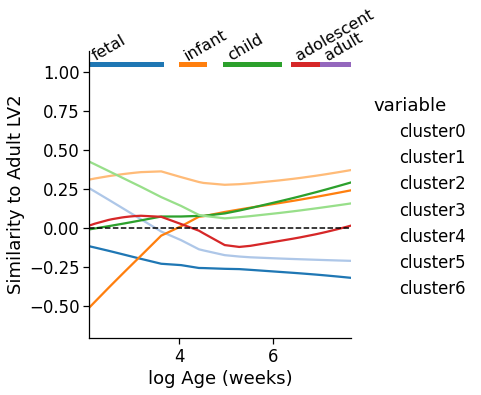

In [96]:
# plot the trajectory of all clusters


sns.set_context('notebook',font_scale=1.5)
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',palette='tab20',
             #palette=['gray']*len(tall.variable.unique()),#palette=colors,
             #legend=None,
             data=tall)
plt.ylabel('Similarity to Adult LV2')
plt.xlabel('log Age (weeks)')

for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
#plt.savefig(os.path.join(fig_dir,'EGenes_C2_ClusterTimelines.pdf'),bbox_inches='tight')

In [97]:
tall.to_csv('data/BSDevGens_C2_7clus.csv')

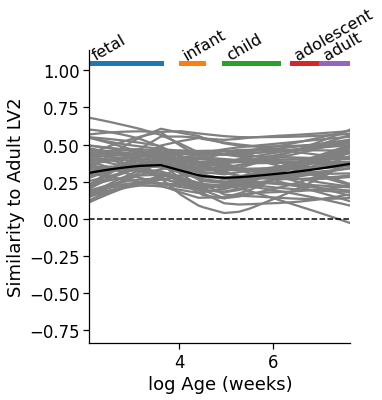

In [98]:
# plot the trajectory of all genes in cluster 5

c5plots = pandas.DataFrame(data[data.labels==3].T,copy=True)
c5plots.drop('labels',inplace=True)
c5plots.loc[:,'ind'] = range(len(c5plots))
c5plots.loc[:,'log_age_weeks'] = subsum.loc[c5plots.index,'log_age_weeks'].values
gtall = pandas.melt(c5plots,id_vars='ind',
                   value_vars=[x for x in c5plots.columns if '_r' in x])
gtall.loc[:,'log_age_weeks'] = c5plots.log_age_weeks.tolist() * len(gtall.variable.unique())

sns.set_context('notebook',font_scale=1.5)
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',#palette='tab10',
             palette=['gray']*len(tall.variable.unique()),#palette=colors,
             legend=None,
             data=gtall)
sns.regplot(x=cplots.log_age_weeks.values,y=cplots.cluster3.values,color='black',
           marker='',lowess=True)
plt.ylabel('Similarity to Adult LV2')
plt.xlabel('log Age (weeks)')

for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
# plt.savefig(os.path.join(fig_dir,'EGenes_C2_ClusterTimelines_7Clus_3.pdf'),
#             bbox_inches='tight')

In [99]:
# meet the genes
[x.split('_')[0] for x in c5plots.columns if '_r' in x]

['TP53I3',
 'NR2F2',
 'SLFN11',
 'PLOD2',
 'ZNF503',
 'SNX31',
 'CD86',
 'NAP1L6',
 'SV2C',
 'AGT',
 'NMB',
 'GABRE',
 'MTHFD2L',
 'TRPV2',
 'DRD2',
 'MEI1',
 'CST3',
 'LRPAP1',
 'CHI3L1',
 'ACBD7',
 'PLA2G5',
 'IL33',
 'FANK1',
 'CDH11',
 'SLC30A10',
 'HHAT',
 'LRRN1',
 'KCNA5',
 'DNALI1',
 'SKAP1',
 'VWA5A',
 'CLIC5',
 'RBP1',
 'GAL',
 'EDN1',
 'STXBP6',
 'CNGB1',
 'TSPAN2',
 'RTP1',
 'WNT10A',
 'SEMA5A',
 'AMIGO2',
 'SIX3',
 'FABP6',
 'MEIS2',
 'MGAT4C',
 'BMP8B',
 'HRH3',
 'SYT10',
 'HSPB8',
 'ZMYND10',
 'CTXN3',
 'TGFBI',
 'CD6']

In [100]:
c1labs = pandas.concat([pandas.Series([x.split('_')[0] for x in data.index]),
               pandas.Series(data.labels.values)],
              axis=1)
c1labs.columns = ['Gene','Cluster']
c1labs.to_csv('data/C2_devclusters.csv')

### C3
Adn we'll just repeat this all once more for C3

In [101]:
subsum = pandas.read_csv('data/BioInf_rvals_C3_rotated.csv',index_col=0)

In [103]:
# Get the significant C2 genes
c=3
perc = 0.025 / 3
thresh = int(round(all_comps.shape[0] * perc))
genes = all_comps.sort_values('C%s'%c).dropna().gene_symbol.tolist()[:thresh]
genes += all_comps.sort_values('C%s'%c).dropna().gene_symbol.tolist()[-thresh:]
topgenes = pandas.DataFrame(genes)
topgenes.columns = ['C3']

In [104]:
cols = ['donor_id', 'donor_name', 'age', 
        'gender','structure_id', 'structure_acronym', 'structure_name',
       'Age_Stage', 'Age_Epoch', 'Age_Period',
       'MacroStructure', 'MacroStructure2', 'NT_Segment', 'Sensorifugal',
       'age_level','age_in_months',
       'log_age_months','age_in_weeks','log_age_weeks']
for col in cols:
    subsum.loc[:,col] = gdf.groupby('donor_id')[col].first().loc[subsum.index].values

In [105]:
c2ss = pandas.DataFrame(subsum[[x+'_r' for x in topgenes.C3.values if x+'_r' in subsum.columns]
                              ].dropna(),copy=True)
c2ss.drop([x for x in c2ss.index if all(~pandas.notnull(c2ss.loc[x]))],axis=0,inplace=True)
c2ss.drop([x for x in c2ss.columns if any(~pandas.notnull(c2ss.loc[:,x]))],axis=1,inplace=True)

In [106]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.cluster import AgglomerativeClustering
csol = pandas.DataFrame()
for i,k in enumerate(range(2,50)):
    #print('working on k =',k)
    d = c2ss.T.values
    cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', 
                                  linkage='ward')
    cluster.fit_predict(d)
    csol.loc[i,'k'] = k
    csol.loc[i,'sil_score'] = silhouette_score(d,cluster.labels_,random_state=123)
    csol.loc[i,'ch_score'] = calinski_harabasz_score(d,cluster.labels_)

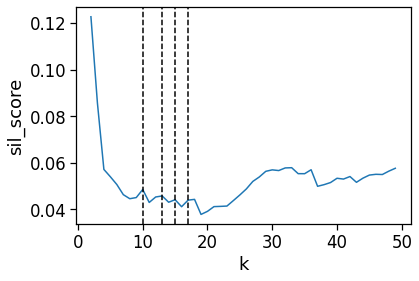

In [109]:
sns.lineplot(x='k',y='sil_score',data=csol)
peaks = [10,13,15,17]
for peak in peaks:
    plt.axvline(peak,ls='--',c='k')

<AxesSubplot:>

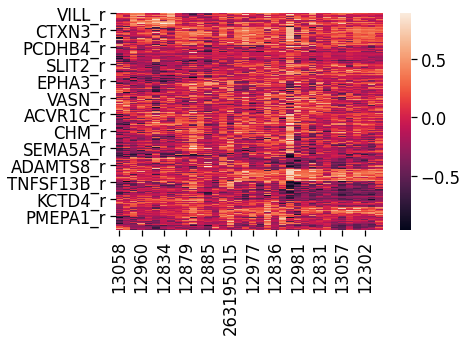

In [122]:
# cluster once more based on peak
cluster = AgglomerativeClustering(n_clusters=17, affinity='euclidean', 
                                  linkage='ward')
cluster.fit_predict(c2ss.T.values)
# sort data by cluster labels and plot
data = pandas.DataFrame(c2ss.T,copy=True)
data.loc[:,'labels'] = cluster.labels_
sorted_ind = [x for x in subsum.sort_values('log_age_weeks').index if x in data.columns]
sns.heatmap(data.sort_values('labels')[sorted_ind])

In [125]:
c2ss.to_csv('data/BSDevGens_C3_ss_17clus.csv')

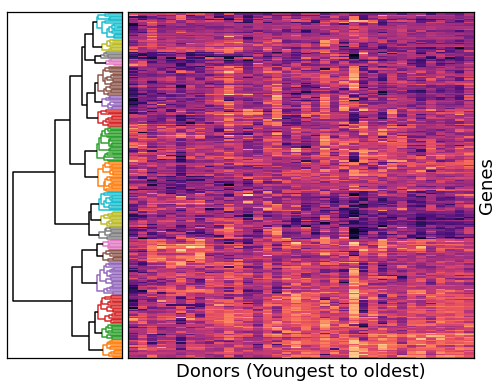

In [126]:
# Now make a version for visualization in the paper
import scipy.cluster.hierarchy as shc

# get the dendogram for the clustering solution
link = shc.linkage(c2ss.T.values, method='ward')
#dend = shc.dendrogram(link)

# get an index ordering that sorts by age
sorder = [x for x in subsum.sort_values('log_age_weeks').donor_id.values if x in c2ss.T.columns]

# define data
D = pandas.DataFrame(c2ss.T[sorder], copy=True)
D = D.values

# create dendogram
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_axes([0.09, 0.1, 0.2, 0.6])
Y = link
shc.set_link_color_palette(None)
Z1 = shc.dendrogram(Y, orientation='left',color_threshold=3.32,above_threshold_color='black',)
ax1.set_xticks([])
ax1.set_yticks([])

# main heat-map
axmatrix = fig.add_axes([0.3, 0.1, 0.6, 0.6])
idx1 = Z1['leaves']
D = D[idx1, :]
# the actual heat-map
im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap="magma",vmin=-1,vmax=1)

# decorate
axmatrix.set_xticks([])
axmatrix.set_yticks([])
axmatrix.yaxis.set_label_position('right')
plt.xlabel('Donors (Youngest to oldest)',)
plt.ylabel('Genes')

#plt.savefig(os.path.join(fig_dir,'EGenes_DendoC3_17clus.pdf'),bbox_inches='tight')
plt.show()

In [123]:
cplots = data.groupby('labels').mean().T
cplots.columns = ['cluster%s'%x for x in cplots.columns]
for col in subsum.columns[:20]:
    cplots.loc[:,col] = subsum.loc[c2ss.index,col].values
cplots.head()

,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,...,Age_Period,MacroStructure,MacroStructure2,NT_Segment,Sensorifugal,age_level,age_in_months,log_age_months,age_in_weeks,log_age_weeks
13058,-0.026722,-0.176990,-0.282766,-0.045219,-0.076860,0.115120,-0.336975,-0.396843,-0.563767,-0.195055,...,p2,Occipital,Occipital,Tele,Association,0,1.839080,0.609266,8.0,2.079442
12833,-0.046710,0.034252,-0.180360,-0.060194,-0.007237,0.150404,-0.247519,-0.171083,-0.429780,-0.037608,...,p2,Frontal,Frontal,Tele,Association,1,2.068966,0.727049,9.0,2.197225
12835,0.372805,-0.118654,0.065151,-0.217810,-0.238740,-0.101163,0.002008,-0.263882,-0.588775,0.116670,...,p3,Limbic,Limbic,Tele,Association,2,2.758621,1.014731,12.0,2.484907
12960,0.299513,0.066585,-0.162589,-0.143991,-0.205436,0.052329,-0.044699,-0.191226,-0.277913,-0.021773,...,p3,Temporal,Temporal,Tele,Association,2,2.758621,1.014731,12.0,2.484907
13060,0.208779,0.084037,-0.065687,-0.231738,-0.127752,0.055769,0.150599,-0.107304,-0.395117,-0.079783,...,p3,Limbic,Limbic,Tele,Association,2,2.758621,1.014731,12.0,2.484907


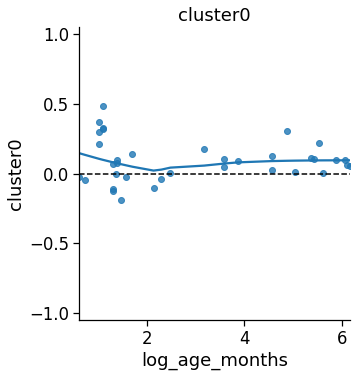

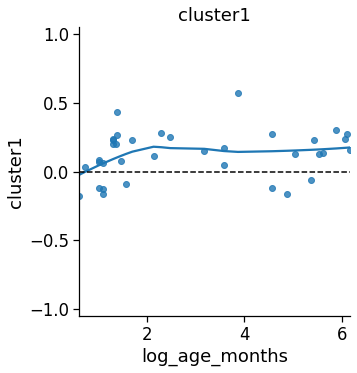

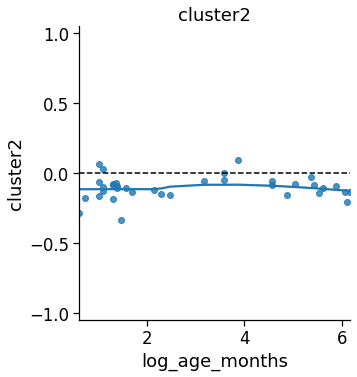

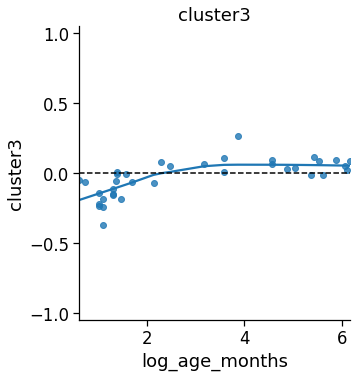

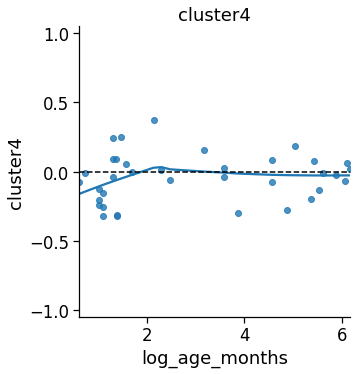

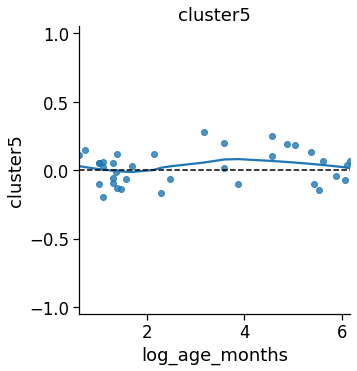

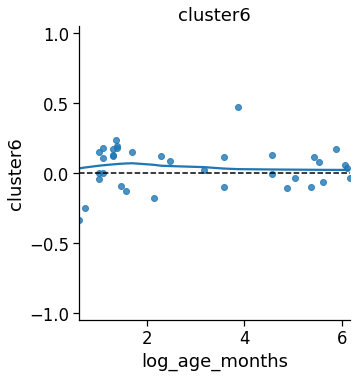

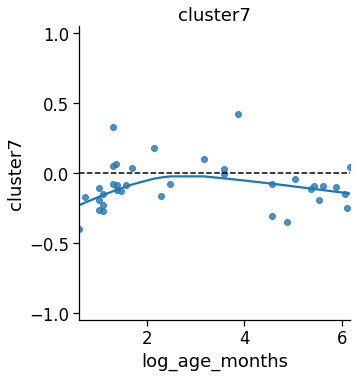

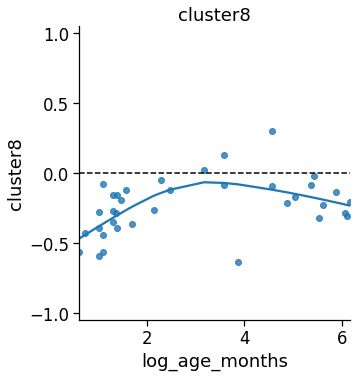

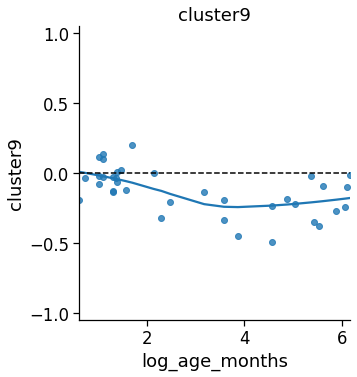

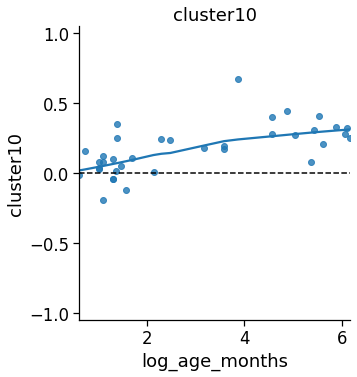

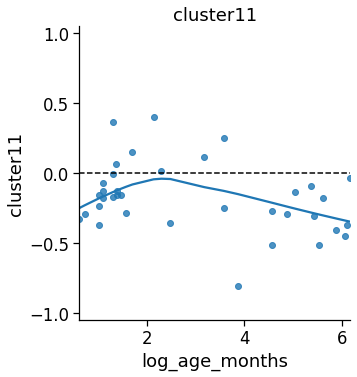

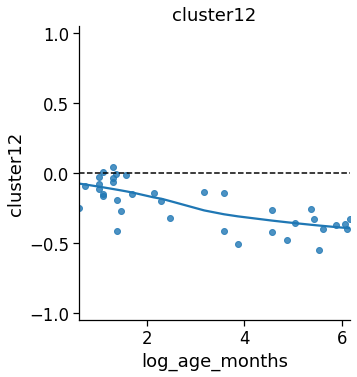

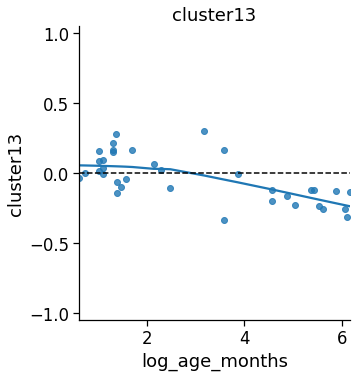

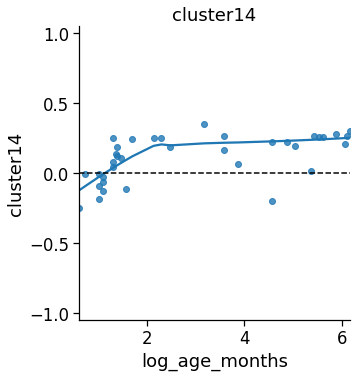

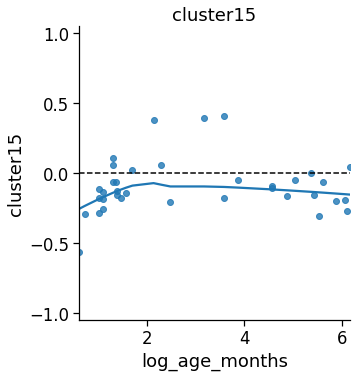

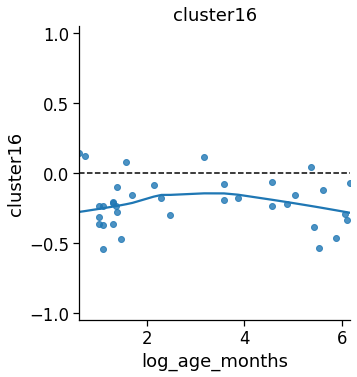

In [124]:
# making plotting dataframe
cplots.loc[:,'ind'] = cplots.index
tall = pandas.melt(cplots,id_vars='ind',
                   value_vars=[x for x in cplots.columns if 'cluster' in x])
tall.loc[:,'log_age_weeks'] = cplots.log_age_weeks.tolist() * len(tall.variable.unique())
# for each cluster
for cluster in [x for x in cplots.columns if 'cluster' in x]:
    # plot expression over log age
    g=sns.lmplot(x='log_age_months',y=cluster,
            #hue='gender',
            lowess=True,
             #scatter_kws={'color':'k'},
           data=cplots)
    # decorate
    plt.ylim(-1.05,1.05)
    plt.axhline(0,ls='--',c='k')
    plt.title(cluster)
    plt.show()

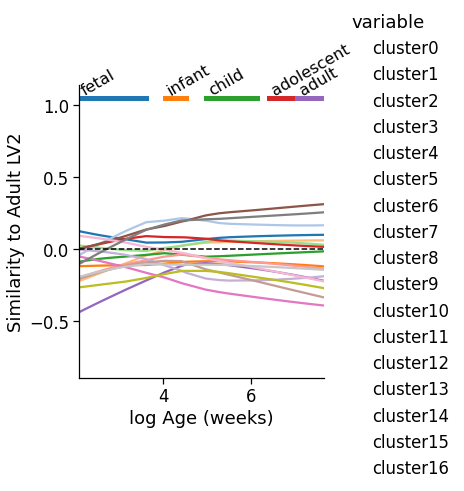

In [127]:
# plot the trajectory of all clusters


sns.set_context('notebook',font_scale=1.5)
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',palette='tab20',
             #palette=['gray']*len(tall.variable.unique()),#palette=colors,
             #legend=None,
             data=tall)
plt.ylabel('Similarity to Adult LV2')
plt.xlabel('log Age (weeks)')

for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
# plt.savefig(os.path.join(fig_dir,'EGenes_C3_ClusterTimelines.pdf'),bbox_inches='tight')

In case it's not obvious, I'd like to point out that the analysis in LV3 is far more questionable than that of LV1 and LV2. The cluster we are going with (#17 in dark yellow) has a pretty low similarity to adult expression relative to the other LVs. It also took a lot more clusters to find a cluster behaving like this. There's fair reason to believe this is truly an component that is emergent in later development. But we will continue forward with this analysis anyway for the sake of completion.

Note also this cluster has a negative r value. That's fine, but for the purposes of consistency for the manuscript plot and to assail confusion, we will invert it's values later on (it doesn't really matter, negative or positive values both indicate similarity to the LV)

In [128]:
tall.to_csv('data/BSDevGens_C3_17clus.csv')

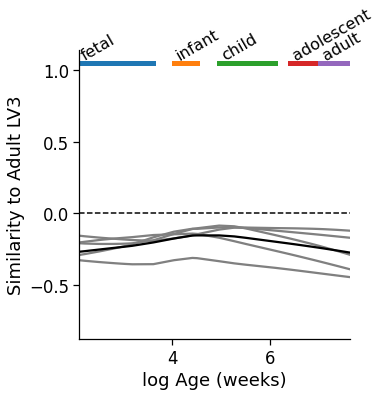

In [130]:
# plot the trajectory of all genes in cluster 5

c5plots = pandas.DataFrame(data[data.labels==16].T,copy=True)
c5plots.drop('labels',inplace=True)
c5plots.loc[:,'ind'] = range(len(c5plots))
c5plots.loc[:,'log_age_weeks'] = subsum.loc[c5plots.index,'log_age_weeks'].values
gtall = pandas.melt(c5plots,id_vars='ind',
                   value_vars=[x for x in c5plots.columns if '_r' in x])
gtall.loc[:,'log_age_weeks'] = c5plots.log_age_weeks.tolist() * len(gtall.variable.unique())

sns.set_context('notebook',font_scale=1.5)
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',#palette='tab10',
             palette=['gray']*len(tall.variable.unique()),#palette=colors,
             legend=None,
             data=gtall)
sns.regplot(x=cplots.log_age_weeks.values,y=cplots.cluster16.values,color='black',
           marker='',lowess=True)
plt.ylabel('Similarity to Adult LV3')
plt.xlabel('log Age (weeks)')

for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
# plt.savefig(os.path.join(fig_dir,'EGenes_C3_ClusterTimelines_17Clus_15.pdf'),
#             bbox_inches='tight')

In [131]:
# meet the genes
[x.split('_')[0] for x in c5plots.columns if '_r' in x]

['PID1', 'ERLIN1', 'LIG1', 'RHCG', 'EFNB1']

In [132]:
c1labs = pandas.concat([pandas.Series([x.split('_')[0] for x in data.index]),
               pandas.Series(data.labels.values)],
              axis=1)
c1labs.columns = ['Gene','Cluster']
c1labs.to_csv('data/C3_devclusters.csv')

As mentioned above, these analyses will be followed up in the next notebook